In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

np.random.seed(13)

### Данные

In [2]:
data = load_digits()

In [3]:
X = data['data']
y = (data['target'] >= 5).astype(np.int32)

<Figure size 432x288 with 0 Axes>

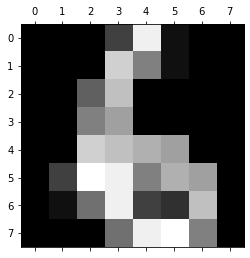

6


In [4]:
plt.gray()
index = np.random.randint(0, len(X) - 1)
plt.matshow(X[index].reshape(8, 8))
plt.show()
print(data.target[index])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.77,
                                                    shuffle=True)

In [6]:
X_train.shape, X_test.shape

((1383, 64), (414, 64))

### Логистическая регрессия

Вычисление предсказания логистической регрессией для объекта $x_i \in \mathbb{R}^n$ :

* $z = w^T x_i + b, \quad w \in \mathbb{R}^n, b \in \mathbb{R}$
* $a = \sigma (z)$

Сигмоида

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png)

Логистическая фунция потерь:

$$L_i(a) = -y_i \cdot log(a) - (1 - y_i) \cdot log(1 - a)$$

Производные функции по параметрам:

$$\frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial w} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot x_i = (a-y_i) \cdot x_i $$

$$\frac{\partial L_i}{\partial b} = \frac{\partial L_i}{\partial a} \cdot \frac{\partial a}{\partial z} 
\cdot \frac{\partial z}{\partial b} = \frac {a - y_i} {a \cdot (1-a)} \cdot a \cdot (1-a) \cdot 1 = a-y_i $$

Используются для минимизации функции потерь $L$ с помощью градиентного спуска.

In [7]:
def log_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred), axis=0) / len(y_true)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
m, n = X_train.shape
print(f'Число объектов в обучающей выборке: {m}\nРазмерность объекта: {n}')

Число объектов в обучающей выборке: 1383
Размерность объекта: 64


In [9]:
class LogisticRegression:
    
    def __init__(self):
        self.w = np.random.randn(n, 1) * 0.001
        self.b = np.random.randn() * 0.001
        self.report_every = 40

    def train(self, X, y, learning_rate=0.005, epochs=40):
        self.losses_train = []
        self.losses_test = []
        
        for epoch in range(epochs):            
            dw = np.zeros((n, 1))
            db = 0
            
            for i in range(len(X)):
                # forward propagation
                z = X[i].reshape(1, n).dot(self.w) + self.b
                a = sigmoid(z)[0][0]
                
                # gradient calculation
                dw += (a - y[i]) * X[i].reshape(n, 1)
                db += (a - y[i])
                
            dw /= len(X)
            db /= len(X)
            
            # gradient step
            self.w = self.w - learning_rate * dw
            self.b = self.b - learning_rate * db
            
            # save loss for plotting
            if epoch % self.report_every == 0:
                self.losses_train.append(log_loss(y, self.predict(X)))
                self.losses_test.append(log_loss(y_test, self.predict(X_test)))
        

    def train_vec(self, X, y, learning_rate=0.005, epochs=40):
        self.losses_train = []
        self.losses_test = []
        
        for epoch in range(epochs):            
            Z = X.reshape(m, n).dot(self.w) + self.b
            A = sigmoid(Z)
            
            dw = np.sum(X.reshape(m, n) * (A.reshape(m, 1) - y.reshape(m, 1)), axis=0) / len(X)
            db = np.sum((A.reshape(m, 1) - y.reshape(m, 1)), axis=0) / len(X)
            
            # gradient step
            self.w = self.w - learning_rate * dw.reshape(n, 1)
            self.b = self.b - learning_rate * db
            
            # save loss for plotting
            if epoch % self.report_every == 0:
                self.losses_train.append(log_loss(y, self.predict(X)))
                self.losses_test.append(log_loss(y_test, self.predict(X_test)))
    

    def predict(self, X):        
        return np.array([sigmoid(x.reshape(1, n).dot(self.w) + self.b)[0][0] 
                         for x in X])

### Используя цикл

In [10]:
%%time
logreg = LogisticRegression()
logreg.train(X_train, y_train, epochs=500)

CPU times: total: 10.1 s
Wall time: 10.5 s


 #### Обучалось примерно 7 секунд

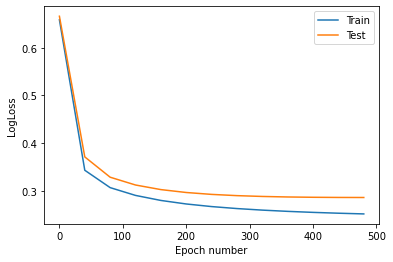

In [11]:
domain = np.arange(0, len(logreg.losses_train)) * logreg.report_every
plt.plot(domain, logreg.losses_train, label='Train')
plt.plot(domain, logreg.losses_test, label='Test')
plt.xlabel('Epoch number')
plt.ylabel('LogLoss')
plt.legend();

In [12]:
test_prediction = np.array(logreg.predict(X_test))
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f'Точность на тестовой выборке: {round(test_accuracy * 100, 2)}%')

Точность на тестовой выборке: 89.13%


In [13]:
train_prediction = np.array(logreg.predict(X_train))
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f'Точность на тестовой выборке: {round(train_accuracy * 100, 2)}%')

Точность на тестовой выборке: 90.96%


### Используя векторизацию

In [14]:
%%time
logreg = LogisticRegression()
logreg.train_vec(X_train, y_train, epochs=500)

CPU times: total: 781 ms
Wall time: 465 ms


####  Обучалось примерно 0.26 секунд

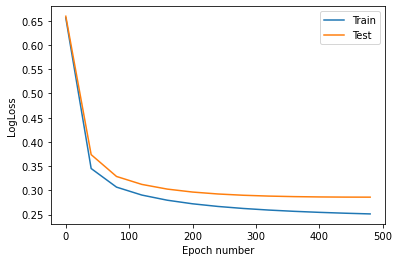

In [15]:
domain = np.arange(0, len(logreg.losses_train)) * logreg.report_every
plt.plot(domain, logreg.losses_train, label='Train')
plt.plot(domain, logreg.losses_test, label='Test')
plt.xlabel('Epoch number')
plt.ylabel('LogLoss')
plt.legend();

In [16]:
test_prediction = np.array(logreg.predict(X_test))
test_accuracy = np.sum((test_prediction > 0.5) == y_test) / len(test_prediction)
print(f'Точность на тестовой выборке: {round(test_accuracy * 100, 2)}%')

Точность на тестовой выборке: 89.13%


In [17]:
train_prediction = np.array(logreg.predict(X_train))
train_accuracy = np.sum((train_prediction > 0.5) == y_train) / len(train_prediction)
print(f'Точность на тестовой выборке: {round(train_accuracy * 100, 2)}%')

Точность на тестовой выборке: 90.89%
